In [ ]:
import os
import copy
import random
import collections
import itertools
import numpy as np
import pandas as pd
import lightgbm as lgb
import warnings
import joblib
from sklearn.model_selection import train_test_split,RandomizedSearchCV
import sklearn.metrics as metrics
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.utils import resample
import lightgbm as lgb
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier

<Figure size 800x400 with 0 Axes>

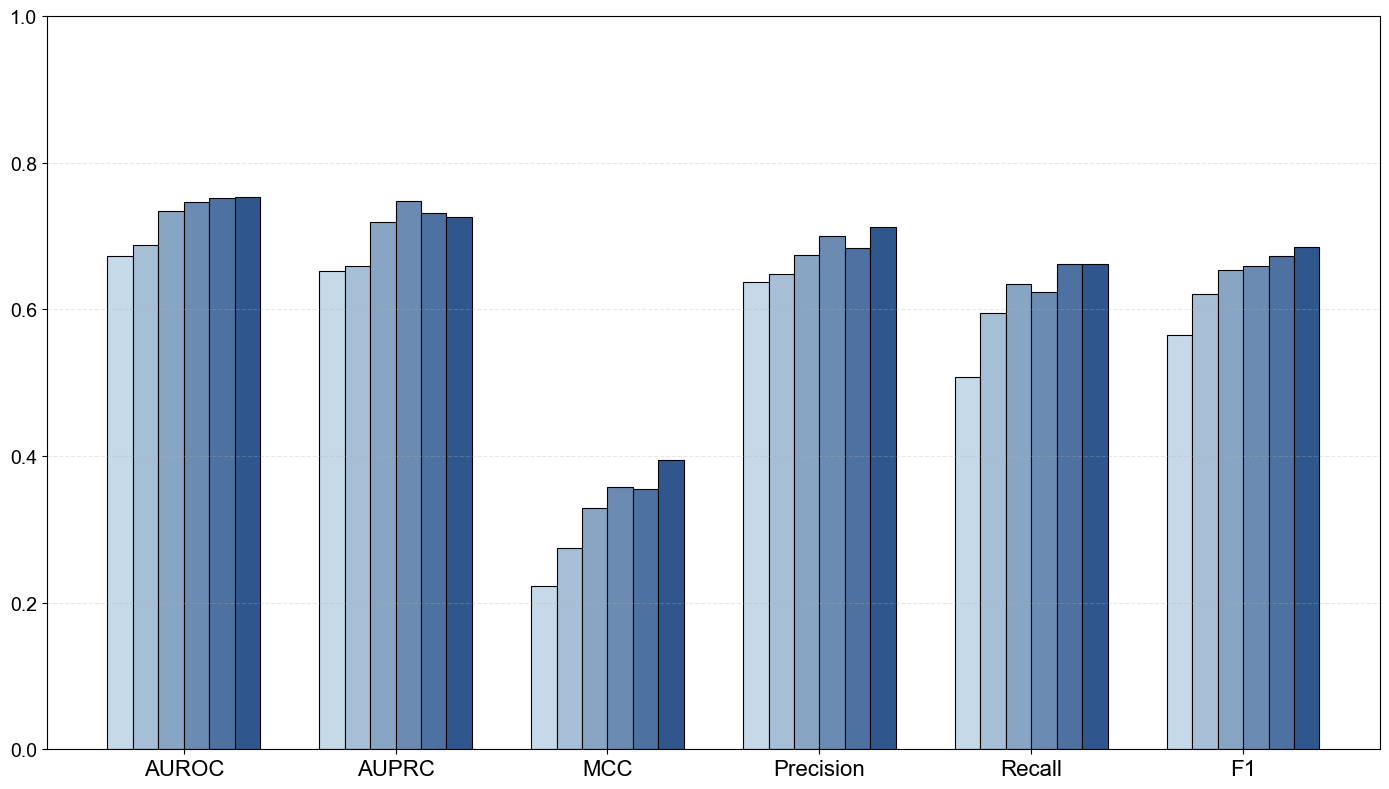

模型按AUROC从低到高排序:
1. SVM: AUROC = 0.6731
2. LR: AUROC = 0.6880
3. NGBoost: AUROC = 0.7342
4. LightGBM: AUROC = 0.7458
5. CatBoost: AUROC = 0.7522
6. Random_Forest: AUROC = 0.7530


In [28]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(8, 4))

# 原始模型数据
original_models = ['LR', 'SVM', 'CatBoost', 'LightGBM', 'Random_Forest', 'NGBoost']
metrics = ['AUROC', 'AUPRC', 'MCC', 'Precision', 'Recall', 'F1']

# 原始数据矩阵 (模型 x 指标)
original_data = np.array([
    [0.6880, 0.6594, 0.2741, 0.6488, 0.5956, 0.6211],  # LR
    [0.6731, 0.6528, 0.2232, 0.6370, 0.5082, 0.5653],  # SVM
    [0.7522, 0.7311, 0.3554, 0.6836, 0.6612, 0.6722],  # CatBoost
    [0.7458, 0.7478, 0.3573, 0.6994, 0.6230, 0.6590],  # LightGBM
    [0.7530, 0.7262, 0.3944, 0.7118, 0.6612, 0.6856],  # Random_Forest
    [0.7342, 0.7195, 0.3285, 0.6744, 0.6339, 0.6535]   # NGBoost
])

# 根据AUROC排序（从低到高）
auroc_values = original_data[:, 0]  # AUROC是第0列
sorted_indices = np.argsort(auroc_values)

# 重新排列模型和数据
models = [original_models[i] for i in sorted_indices]
data = original_data[sorted_indices]

# 配色方案 - 按AUROC排序后颜色依次加深
cool_colors = [
    '#D4E6F1', '#C5D9E8', '#B6CCDF', '#A7BFD6', '#98B2CD',
    '#89A5C4', '#7A98BB', '#6B8BB2', '#5C7EA9', '#4D71A0',
    '#3E6497', '#2F578E', '#204A85', '#113D7C'
]

# 为6个模型分配颜色，从浅到深
model_colors = [cool_colors[i] for i in [1, 3, 5, 7, 9, 11]]

# 设置图形参数
fig, ax = plt.subplots(figsize=(14, 8))
n_metrics = len(metrics)
n_models = len(models)
bar_width = 0.12
x = np.arange(n_metrics)

# 绘制分组柱状图
for i, model in enumerate(models):
    offset = (i - n_models/2 + 0.5) * bar_width
    bars = ax.bar(x + offset, data[i], bar_width, 
                  label=model, color=model_colors[i], 
                  edgecolor='black', linewidth=0.8)

# 设置图形属性
ax.set_xticks(x)
ax.set_xticklabels(metrics, fontsize=16)
ax.tick_params(axis='y', labelsize=14)
ax.set_ylim(0, 1.0)
ax.grid(axis='y', alpha=0.3, linestyle='--')

# 调整布局
plt.tight_layout()
plt.show()

# 打印排序后的模型顺序和对应的AUROC值
print("模型按AUROC从低到高排序:")
for i, model in enumerate(models):
    print(f"{i+1}. {model}: AUROC = {data[i][0]:.4f}")

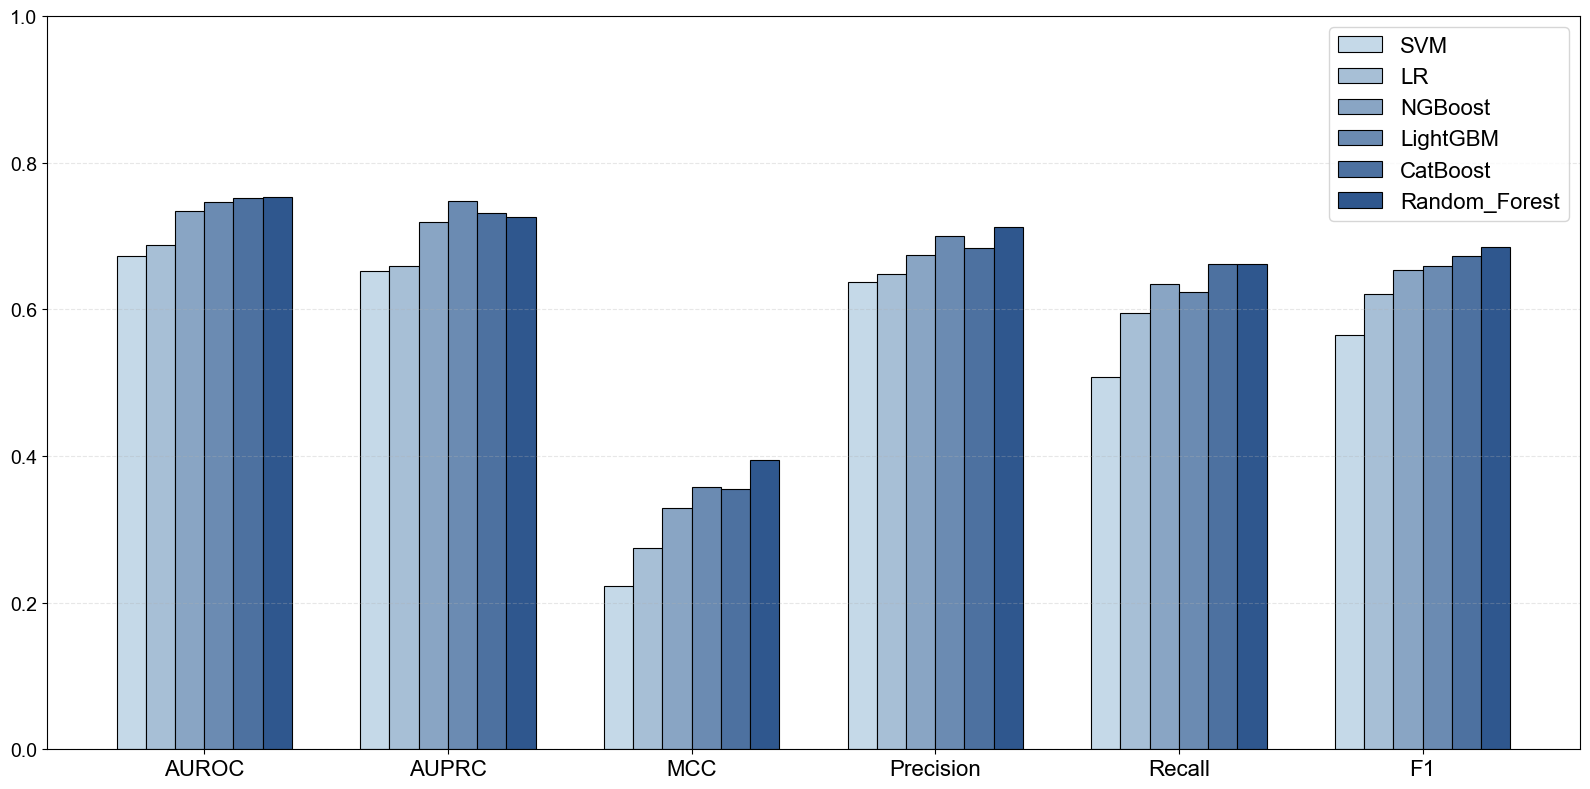

模型按AUROC从低到高排序:
1. SVM: AUROC = 0.6731
2. LR: AUROC = 0.6880
3. NGBoost: AUROC = 0.7342
4. LightGBM: AUROC = 0.7458
5. CatBoost: AUROC = 0.7522
6. Random_Forest: AUROC = 0.7530


In [42]:
import matplotlib.pyplot as plt
import numpy as np


# 原始模型数据
original_models = ['LR', 'SVM', 'CatBoost', 'LightGBM', 'Random_Forest', 'NGBoost']
metrics = ['AUROC', 'AUPRC', 'MCC', 'Precision', 'Recall', 'F1']

# 原始数据矩阵 (模型 x 指标)
original_data = np.array([
    [0.6880, 0.6594, 0.2741, 0.6488, 0.5956, 0.6211],  # LR
    [0.6731, 0.6528, 0.2232, 0.6370, 0.5082, 0.5653],  # SVM
    [0.7522, 0.7311, 0.3554, 0.6836, 0.6612, 0.6722],  # CatBoost
    [0.7458, 0.7478, 0.3573, 0.6994, 0.6230, 0.6590],  # LightGBM
    [0.7530, 0.7262, 0.3944, 0.7118, 0.6612, 0.6856],  # Random_Forest
    [0.7342, 0.7195, 0.3285, 0.6744, 0.6339, 0.6535]   # NGBoost
])

# 根据AUROC排序（从低到高）
auroc_values = original_data[:, 0]  # AUROC是第0列
sorted_indices = np.argsort(auroc_values)

# 重新排列模型和数据
models = [original_models[i] for i in sorted_indices]
data = original_data[sorted_indices]

# 配色方案 - 按AUROC排序后颜色依次加深
cool_colors = [
    '#D4E6F1', '#C5D9E8', '#B6CCDF', '#A7BFD6', '#98B2CD',
    '#89A5C4', '#7A98BB', '#6B8BB2', '#5C7EA9', '#4D71A0',
    '#3E6497', '#2F578E', '#204A85', '#113D7C'
]

# 为6个模型分配颜色，从浅到深
model_colors = [cool_colors[i] for i in [1, 3, 5, 7, 9, 11]]

# 设置图形参数
fig, ax = plt.subplots(figsize=(16, 8))
n_metrics = len(metrics)
n_models = len(models)
bar_width = 0.12
x = np.arange(n_metrics)

# 绘制分组柱状图
for i, model in enumerate(models):
    offset = (i - n_models/2 + 0.5) * bar_width
    bars = ax.bar(x + offset, data[i], bar_width, 
                  label=model, color=model_colors[i], 
                  edgecolor='black', linewidth=0.8)

# 设置图形属性
ax.set_xticks(x)
ax.set_xticklabels(metrics, fontsize=16)
ax.tick_params(axis='y', labelsize=14)
ax.set_ylim(0, 1.0)
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.legend(fontsize=16, loc='upper right')

# 调整布局
plt.tight_layout()
plt.show()

# 打印排序后的模型顺序和对应的AUROC值
print("模型按AUROC从低到高排序:")
for i, model in enumerate(models):
    print(f"{i+1}. {model}: AUROC = {data[i][0]:.4f}")

/tmp/ipykernel_20789/2972563107.py:49: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in legend.legendHandles:


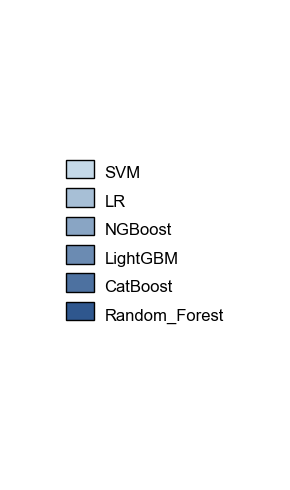

In [29]:
import matplotlib.pyplot as plt

# ===== 输入数据 =====
# 模型名称
models = ['SVM', 'LR', 'NGBoost', 'LightGBM', 'CatBoost', 'Random_Forest']

# 配色方案 - 使用cool_colors
cool_colors = [
    '#D4E6F1', '#C5D9E8', '#B6CCDF', '#A7BFD6', '#98B2CD',
    '#89A5C4', '#7A98BB', '#6B8BB2', '#5C7EA9', '#4D71A0',
    '#3E6497', '#2F578E', '#204A85', '#113D7C'
]

# 为模型选择颜色
model_colors = [cool_colors[i] for i in [1, 3, 5, 7, 9, 11]]

# ===== 公共绘图函数 =====
def plot_model_legend(models, colors, filename, labelspacing=0.6, markersize=12, figsize=(3, 5)):
    """
    绘制模型与颜色对应的图例，并保存为透明背景图片
    专门用于堆积柱状图
    """
    plt.rcParams['font.family'] = 'Arial'
    fig, ax = plt.subplots(figsize=figsize)

    handles = []
    for model, color in zip(models, colors):
        # 使用矩形标记，更适合堆积柱状图
        patch = plt.Rectangle(
            (0, 0), 1, 1, facecolor=color, 
            edgecolor='black', linewidth=1,
            label=model
        )
        handles.append(patch)

    legend = ax.legend(
        handles=handles,
        labels=models,
        loc='center',
        ncol=1,
        frameon=False,
        labelspacing=labelspacing,  # 控制行间距
        handlelength=1.5,           # 图例标记长度
        handletextpad=0.8,          # 标记与文本间距
        fontsize=12                 # 字体大小
    )
    
    # 设置图例中矩形的大小
    for handle in legend.legendHandles:
        handle.set_width(markersize/10)
        handle.set_height(markersize/15)
    
    ax.axis('off')

    plt.tight_layout()
    plt.savefig(filename, dpi=300, bbox_inches='tight', transparent=True)
    plt.show()

# 调用函数生成图例
plot_model_legend(models, model_colors, "legend_models.png", labelspacing=0.8, markersize=200)

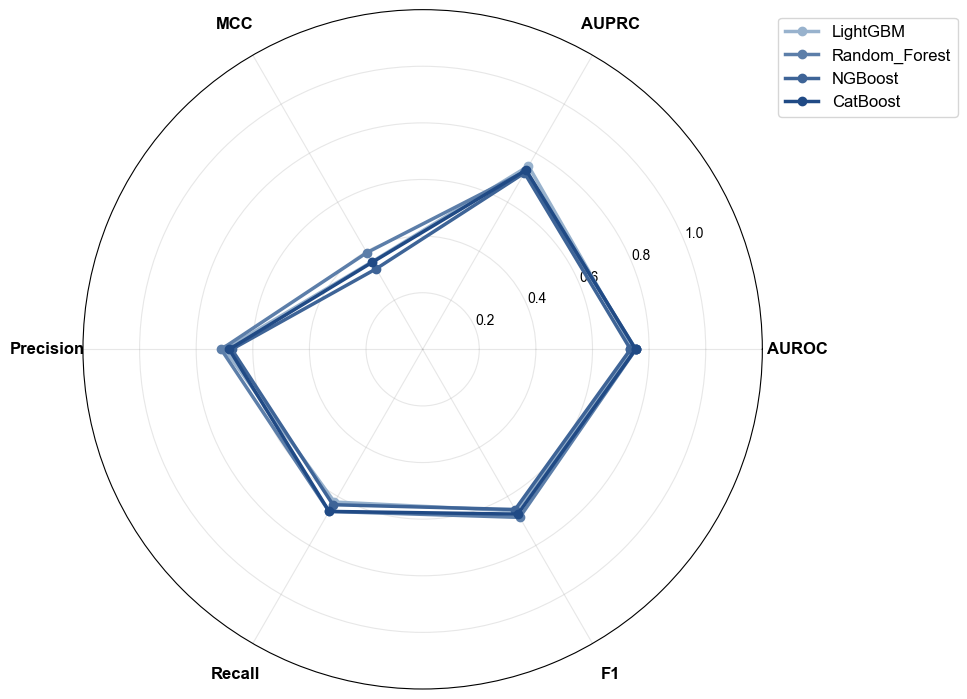

In [25]:
import matplotlib.pyplot as plt
import numpy as np

# 选择的4个模型数据
selected_models = ['LightGBM', 'Random_Forest', 'NGBoost', 'CatBoost']
metrics = ['AUROC', 'AUPRC', 'MCC', 'Precision', 'Recall', 'F1']

# 对应的数据
radar_data = np.array([
    [0.7458, 0.7478, 0.3573, 0.6994, 0.6230, 0.6590],  # LightGBM
    [0.7530, 0.7262, 0.3944, 0.7118, 0.6612, 0.6856],  # Random_Forest
    [0.7342, 0.7195, 0.3285, 0.6744, 0.6339, 0.6535],  # NGBoost
    [0.7522, 0.7311, 0.3554, 0.6836, 0.6612, 0.6722]   # CatBoost
])

# 选择4种颜色
radar_colors = ['#98B2CD', '#5C7EA9', '#3E6497', '#204A85']

# 计算角度
angles = np.linspace(0, 2 * np.pi, len(metrics), endpoint=False)
angles = np.concatenate((angles, [angles[0]]))  # 闭合雷达图

# 创建雷达图
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))

# 为每个模型绘制雷达线
for i, model in enumerate(selected_models):
    values = np.concatenate((radar_data[i], [radar_data[i][0]]))  # 闭合数据
    ax.plot(angles, values, 'o-', linewidth=2.5, label=model, 
            color=radar_colors[i], markersize=6)

# 设置雷达图属性
ax.set_xticks(angles[:-1])
ax.set_xticklabels(metrics, fontsize=12, fontweight='bold')
ax.set_ylim(0, 1.2)  # 增加上限，为标签留出空间
ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_yticklabels(['0.2', '0.4', '0.6', '0.8', '1.0'], fontsize=10)
ax.grid(True, alpha=0.3)

# 方法1：调整标签位置到更外围
ax.tick_params(axis='x', pad=15)  # 增加标签与轴的距离

# 方法2：或者手动设置每个标签的位置
# for angle, metric in zip(angles[:-1], metrics):
#     ax.text(angle, 1.15, metric, ha='center', va='center', 
#             fontsize=12, fontweight='bold')
# ax.set_xticklabels([])  # 隐藏原始标签

# 设置图例
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0), fontsize=12)

# 调整布局
plt.tight_layout()
plt.show()

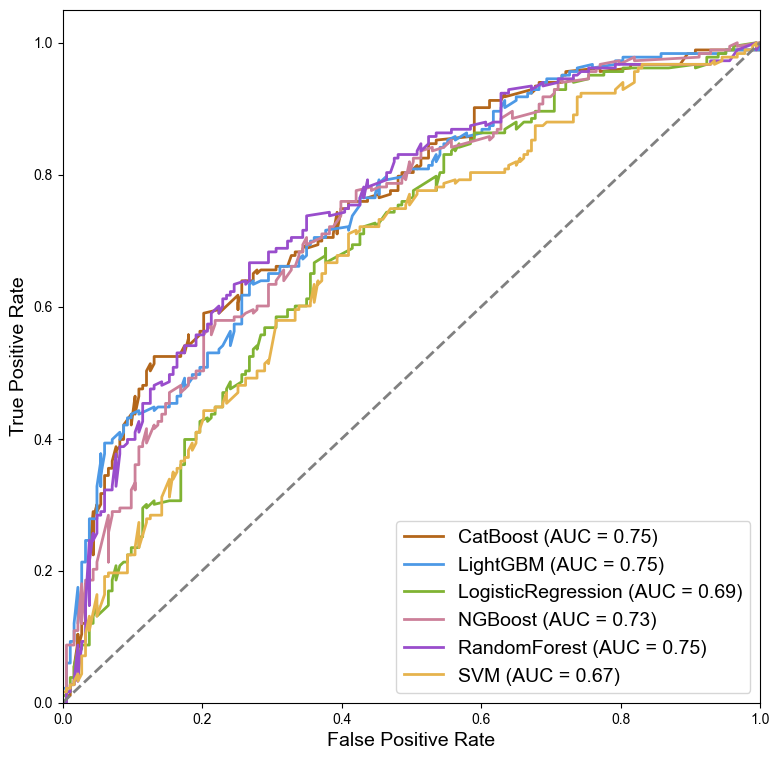

In [35]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

def plot_AUROC(main_path):
    # Prepare figure and line width
    plt.figure(figsize=(9, 9))
    lw = 2
    
    # Prepare 7 low-saturation colors in RGB format
    color_list = [
        (0.7, 0.4, 0.1),  # orange-ish
        (0.3, 0.6, 0.9),  # blue-ish
        (0.5, 0.7, 0.2),  # green-ish
        (0.8, 0.5, 0.6),  # pink-ish
        (0.6, 0.3, 0.8),  # purple-ish
        (0.9, 0.7, 0.3),  # yellow-ish
        (0.4, 0.8, 0.5)   # teal-ish
    ]
    
    # Get list of subfolders (model names), sort alphabetically for consistent color assignment
    subfolders = sorted([d for d in os.listdir(main_path) if os.path.isdir(os.path.join(main_path, d))])
    
    # Limit to 7 models as specified
    if len(subfolders) > 7:
        subfolders = subfolders[:7]
        print("Warning: More than 7 subfolders found. Limiting to the first 7 (alphabetically sorted).")
    
    # Assign colors to models
    model_colors = {model: color_list[i] for i, model in enumerate(subfolders)}
    
    # Function to load data from file and compute AUROC
    def load_roc_data(file_path):
        df = pd.read_csv(file_path, sep='\t')
        fpr = df['FPR'].values
        tpr = df['TPR'].values
        # Ensure fpr is sorted ascending (though it should be)
        sorted_idx = np.argsort(fpr)
        fpr = fpr[sorted_idx]
        tpr = tpr[sorted_idx]
        # Compute AUC using trapezoidal rule
        roc_auc = np.trapz(tpr, fpr)
        return fpr, tpr, roc_auc
    
    # Function to plot a single model's AUROC
    def plot_single_roc(fpr, tpr, roc_auc, label, color):
        plt.plot(fpr, tpr, color=color, lw=lw, label=f'{label} (AUC = {roc_auc:.2f})')
    
    # Plot AUROC for each model
    for model in subfolders:
        file_path = os.path.join(main_path, model, 'AUROC_info.txt')
        if os.path.exists(file_path):
            fpr, tpr, roc_auc = load_roc_data(file_path)
            plot_single_roc(fpr, tpr, roc_auc, model, model_colors[model])
        else:
            print(f"Warning: File {file_path} not found. Skipping {model}.")
    
    # Plot diagonal line (random classifier)
    plt.plot([0, 1], [0, 1], color='grey', lw=lw, linestyle='--')

    # Customize the plot
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate", fontsize=14)
    plt.ylabel("True Positive Rate", fontsize=14)
    # plt.title("AUROC of Models", fontsize=16)
    plt.legend(loc="lower right", fontsize=14)
    
    # Save the plot
    plt.savefig(os.path.join(main_path, "AUROC_Models.pdf"), format="pdf")
    plt.show()

# Example usage:
plot_AUROC('/lulabdata3/huangkeyun/zhangys/RNA_locator/ML_python_scripts/ML_models/circRNA_ML_Model_tridivided_Output')